In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def mktr(x, y):
    return np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])


def mkrot(theta):
    return np.array(
        [
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1],
        ]
    )

In [140]:
def draw_frame(T, ax, axes = 'both', **kwargs):
    x_versor = np.array([[1, 0, 1]])
    y_versor = np.array([[0, 1, 1]])
    origin = np.array([[0, 0, 1]])
    x_frame = T @ x_versor.T
    y_frame = T @ y_versor.T
    orig_frame = T @ origin.T
    
    if axes == 'both':
        ax.plot([orig_frame[0], x_frame[0]], [orig_frame[1], x_frame[1]], 'red')
        ax.plot([orig_frame[0], y_frame[0]], [orig_frame[1], y_frame[1]], 'green')
    elif axes == 'x':
        ax.plot([orig_frame[0], x_frame[0]], [orig_frame[1], x_frame[1]], kwargs.get('color', 'red'))



def draw_wall(x, y, ax):
    ax.plot([x[0], x[1]], [y[0], y[1]], 'blue')




wall = [[2, 0], # x
        [0, 2] # y
]
# draw_frame(robot_frame, ax)



In [213]:
class Tymio:

    def __init__(self, pose, theta_or) -> None:
        assert theta_or < np.pi / 2 and theta_or > 0
        self.theta_or = theta_or
        self.theta_rm = np.pi / 2 - self.theta_or
        self.pose = pose
    
    def right_sensor_frame(self):
        return mkrot(-self.theta_rm) @ self.pose
    
    def middle_sensor_frame(self):
        return self.pose
    
    def left_sensor_frame(self):
        return mkrot(self.theta_rm) @ self.pose
    
    def sensor_length(self, wall):
        """Computes the length of the sensor's ray when it 
        falls on the wall

        Args:
            wall (np.ndarray): Wall ends in the sensor's
            frame of reference. [[x1, x2], [y1, y2]]

        Returns:
            _type_: _description_
        """
        # Compute the formula for the line on which the wall segment lays
        wall_line_gradient = (wall[1, 0] - wall[1, 1]) / (wall[0, 0]- wall[0, 1])
        if np.abs(wall_line_gradient) == np.inf:
            # wall is orthogonal to the sensor's x axis.
            intersection_point_x = wall[0,0]
        else:
            wall_line_intercept = wall[1,0] - wall_line_gradient * wall[0,0]
            # x axis eq: y = 0
            # wall line eq: y = mx + q
            # intersection; 0 = mX + q
            # X = -q/m
            intersection_point_x =  -wall_line_intercept/wall_line_gradient
        wall_length = np.linalg.norm(wall)
        # Does the line intersect the axis?
        # Check distances from both ends of the wall to the
        # point. If the distance from the intersection to the
        # point is larger than the wall's length, then we know
        # that the intersection is not on the wall.
        w1_intersection_distance = np.sqrt((wall[0, 0] - intersection_point_x) ** 2 + wall[1,0]**2)
        w2_intersection_distance = np.sqrt((wall[0, 1] - intersection_point_x) ** 2 + wall[1,1]**2)
        if wall_length > w1_intersection_distance and wall_length > w2_intersection_distance:
            return intersection_point_x
        else:
            return np.inf
    
    def compute_rotation(self, wall):
        dist_R = self.sensor_length((np.linalg.inv(self.right_sensor_frame()) @ wall)[:-1, :])
        dist_L = self.sensor_length((np.linalg.inv(self.left_sensor_frame()) @ wall)[:-1, :])
        dist_M = self.sensor_length((np.linalg.inv(self.middle_sensor_frame()) @ wall)[:-1, :])

        if dist_R < dist_L:
            # Let's assume we are turning right for simplicity
            h2 = dist_R**2 * np.tan(self.theta_rm)**2 / (np.tan(self.theta_rm) ** 2 + 1)
            h = np.sqrt(h2)
            m1 = h / np.tan(self.theta_rm)
            m2 = dist_M - m1
            theta_wr = np.arctan(h / m2)
            print(np.rad2deg(theta_wr))
            return -(np.pi/2 - theta_wr) # CW rotation
        else:
            h2 = dist_L**2 * np.tan(self.theta_rm)**2 / (np.tan(self.theta_rm) ** 2 + 1)
            h = np.sqrt(h2)
            m1 = h / np.tan(self.theta_rm)
            m2 = dist_M - m1
            theta_wr = np.arctan(h / m2)
            print(np.rad2deg(theta_wr))
            return np.pi/2 - theta_wr # CCW rotation

        

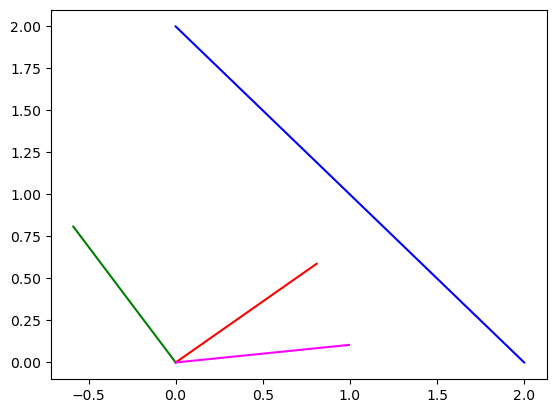

In [222]:
robot_frame = mkrot(np.pi/5)
robot = Tymio(robot_frame, np.deg2rad(60))
fig, ax = plt.subplots(1, 1)
draw_frame(robot.pose, ax)
draw_frame(robot.right_sensor_frame(), ax, axes= 'x', color='magenta')
draw_wall(wall[0], wall[1], ax)

In [223]:
wall_homo = np.append(np.array(wall), np.ones((2, 1)), axis = 1)
wall_right_frame = (np.linalg.inv(robot.right_sensor_frame()) @ wall_homo.T).T

In [224]:
wall_right_frame

array([[ 1.98904379, -0.20905693,  1.        ],
       [ 0.20905693,  1.98904379,  1.        ]])

In [225]:
robot.sensor_length(wall_right_frame[:, :-1].T)

1.8197528295994339

In [226]:
rot = robot.compute_rotation(wall_homo.T)
print(np.rad2deg(rot))

80.99999999999999
9.000000000000012


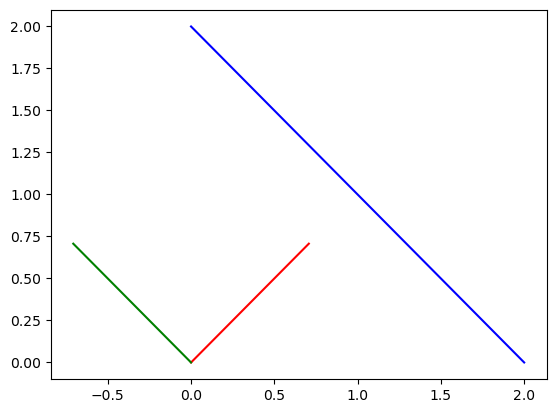

In [227]:
fig, ax = plt.subplots(1, 1)

new_robot_frame = robot.pose @ mkrot(rot)
# draw_frame(robot.pose, ax)
# draw_frame(robot.right_sensor_frame(), ax, axes= 'x', color='magenta')
draw_frame(new_robot_frame, ax)
draw_wall(wall[0], wall[1], ax)

## Noise tolerance tests